# **8-1-1**

In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/F.csv')
df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
36/36 [==============================] - 26s 394ms/step - loss: 0.0172 - val_loss: 0.0089
Epoch 2/100
36/36 [==============================] - 6s 176ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 3/100
36/36 [==============================] - 6s 181ms/step - loss: 8.2644e-04 - val_loss: 0.0063
Epoch 4/100
36/36 [==============================] - 8s 210ms/step - loss: 8.1320e-04 - val_loss: 0.0055
Epoch 5/100
36/36 [==============================] - 6s 167ms/step - loss: 7.7123e-04 - val_loss: 0.0057
Epoch 6/100
36/36 [==============================] - 8s 230ms/step - loss: 7.4144e-04 - val_loss: 0.0052
Epoch 7/100
36/36 [==============================] - 6s 166ms/step - loss: 7.3189e-04 - val_loss: 0.0047
Epoch 8/100
36/36 [==============================] - 8s 221ms/step - loss: 6.7131e-04 - val_loss: 0.0045
Epoch 9/100
36/36 [==============================] - 6s 170ms/step - loss: 6.8839e-04 - val_loss: 0.0043
Epoch 10/100
36/36 [==============================] - 7s 189ms

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 35ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Testing MAE: 15.367955686913222
Testing RMSE: 15.701618620571619
Testing MAPE: 2916.2343676267797
---------------------------
Validation MAE: 11.829295961701499
Validation RMSE: 11.893704246361192
Validation MAPE: 3107.6759097493386


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=240
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.34466478 0.3470255  0.3394712  0.32766761 0.35552408 0.35977337
 0.36213409 0.37771483 0.38904627 0.40462701 0.40982059 0.41690274
 0.43484419 0.44475921 0.41123702 0.4088763  0.39660057 0.38574127
 0.39612842 0.41501416 0.4121813  0.41454202 0.42067989 0.43720491
 0.41926346 0.44853636 0.46175637 0.48677998 0.43531634 0.43106704
 0.44570349 0.44428706 0.44759207 0.41170916 0.42870633 0.4230406
 0.42115203 0.42020774 0.41926346 0.38668555 0.3871577  0.38054769
 0.37157696 0.38007554 0.38054769 0.39235127 0.40321058 0.42823418
 0.42351275 0.41643059 0.42351275 0.39848914 0.38196412 0.37865911
 0.37393768 0.36355052 0.3687441  0.34419263 0.33852691 0.36402266
 0.35269122 0.34985836 0.35410765 0.35457979 0.35835694 0.3796034
 0.39093484 0.40557129 0.40934844 0.41123702 0.39754485 0.39282342
 0.41123702 0.41831917 0.4088763  0.39896128 0.40179415 0.40934844
 0.41170916 0.38762984 0.37110482 0.36827195 0.38479698 0.36638338
 0.35552408 0.35882908 0.37157696 0.38007554 0.36779

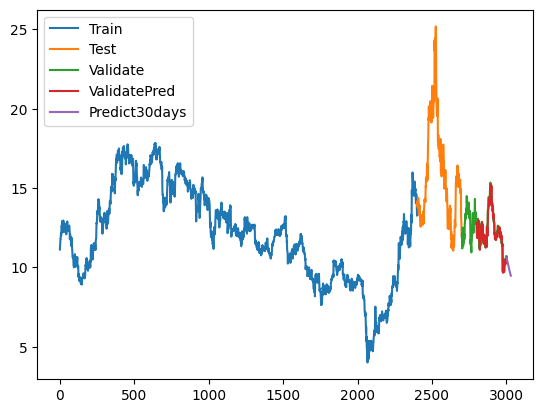

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()

# **7-2-1**

In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/F.csv')
df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
32/32 [==============================] - 14s 282ms/step - loss: 0.0216 - val_loss: 0.0096
Epoch 2/100
32/32 [==============================] - 5s 171ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3/100
32/32 [==============================] - 6s 199ms/step - loss: 8.0597e-04 - val_loss: 0.0041
Epoch 4/100
32/32 [==============================] - 7s 219ms/step - loss: 7.6715e-04 - val_loss: 0.0042
Epoch 5/100
32/32 [==============================] - 6s 172ms/step - loss: 7.6158e-04 - val_loss: 0.0038
Epoch 6/100
32/32 [==============================] - 8s 250ms/step - loss: 7.1643e-04 - val_loss: 0.0036
Epoch 7/100
32/32 [==============================] - 6s 174ms/step - loss: 7.0179e-04 - val_loss: 0.0034
Epoch 8/100
32/32 [==============================] - 6s 203ms/step - loss: 6.8083e-04 - val_loss: 0.0033
Epoch 9/100
32/32 [==============================] - 7s 223ms/step - loss: 6.4247e-04 - val_loss: 0.0033
Epoch 10/100
32/32 [==============================] - 9s 289ms

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 36ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Testing MAE: 13.550842332158602
Testing RMSE: 14.028484409266156
Testing MAPE: 3389.1608935735585
---------------------------
Validation MAE: 11.966212131821738
Validation RMSE: 12.031473655507545
Validation MAPE: 3143.6180408125447


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=240
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.34466478 0.3470255  0.3394712  0.32766761 0.35552408 0.35977337
 0.36213409 0.37771483 0.38904627 0.40462701 0.40982059 0.41690274
 0.43484419 0.44475921 0.41123702 0.4088763  0.39660057 0.38574127
 0.39612842 0.41501416 0.4121813  0.41454202 0.42067989 0.43720491
 0.41926346 0.44853636 0.46175637 0.48677998 0.43531634 0.43106704
 0.44570349 0.44428706 0.44759207 0.41170916 0.42870633 0.4230406
 0.42115203 0.42020774 0.41926346 0.38668555 0.3871577  0.38054769
 0.37157696 0.38007554 0.38054769 0.39235127 0.40321058 0.42823418
 0.42351275 0.41643059 0.42351275 0.39848914 0.38196412 0.37865911
 0.37393768 0.36355052 0.3687441  0.34419263 0.33852691 0.36402266
 0.35269122 0.34985836 0.35410765 0.35457979 0.35835694 0.3796034
 0.39093484 0.40557129 0.40934844 0.41123702 0.39754485 0.39282342
 0.41123702 0.41831917 0.4088763  0.39896128 0.40179415 0.40934844
 0.41170916 0.38762984 0.37110482 0.36827195 0.38479698 0.36638338
 0.35552408 0.35882908 0.37157696 0.38007554 0.36779

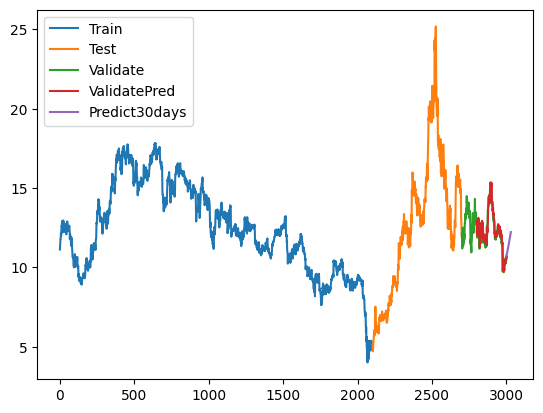

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()

# **6-2-2**

In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/F.csv')
df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
27/27 [==============================] - 13s 223ms/step - loss: 0.0347 - val_loss: 0.0150
Epoch 2/100
27/27 [==============================] - 6s 232ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 3/100
27/27 [==============================] - 6s 204ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 4/100
27/27 [==============================] - 5s 176ms/step - loss: 8.0373e-04 - val_loss: 0.0014
Epoch 5/100
27/27 [==============================] - 7s 244ms/step - loss: 7.5299e-04 - val_loss: 0.0014
Epoch 6/100
27/27 [==============================] - 5s 189ms/step - loss: 7.4378e-04 - val_loss: 0.0014
Epoch 7/100
27/27 [==============================] - 5s 175ms/step - loss: 7.2528e-04 - val_loss: 0.0013
Epoch 8/100
27/27 [==============================] - 7s 250ms/step - loss: 7.1006e-04 - val_loss: 0.0013
Epoch 9/100
27/27 [==============================] - 5s 182ms/step - loss: 6.9349e-04 - val_loss: 0.0013
Epoch 10/100
27/27 [==============================] - 5s 173ms/ste

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

16/16 [==============================] - 1s 36ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Testing MAE: 8.814063902921493
Testing RMSE: 9.211452957562285
Testing MAPE: inf
---------------------------
Validation MAE: 13.564267387064142
Validation RMSE: 13.856917508522049
Validation MAPE: 3118.7093647100855


<ipython-input-40-bc4127aeef2b>:9: RuntimeWarning: divide by zero encountered in divide
  MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=540
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.5401322  0.55193579 0.54532578 0.53871577 0.56798867 0.59206799
 0.57932011 0.56610009 0.56326723 0.54296506 0.60670444 0.6170916
 0.65816808 0.66100094 0.69027384 0.72757318 0.72143532 0.76203966
 0.76062323 0.72474032 0.73371105 0.73135033 0.7483475  0.74504249
 0.75306893 0.73418319 0.72615675 0.7776204  0.76440038 0.7667611
 0.74315392 0.73937677 0.71671388 0.73512748 0.74881964 0.71435316
 0.71813031 0.75306893 0.74598678 0.73465534 0.82341832 0.77525968
 0.75731822 0.76392823 0.77148253 0.74409821 0.72757318 0.73654391
 0.76156752 0.7667611  0.79272899 0.79084042 0.78139754 0.77714825
 0.79131256 0.83852691 0.95845137 0.92776204 0.96553352 0.96458924
 0.93673277 0.96033994 0.96600567 0.99197356 1.         0.96175637
 0.87063267 0.83286119 0.78564684 0.7733711  0.75401322 0.75070822
 0.73371105 0.7332389  0.76912181 0.78611898 0.78470255 0.74976393
 0.65864023 0.65533522 0.64730878 0.67705382 0.66430595 0.63928234
 0.63503305 0.66430595 0.66100094 0.6388102  0.66241

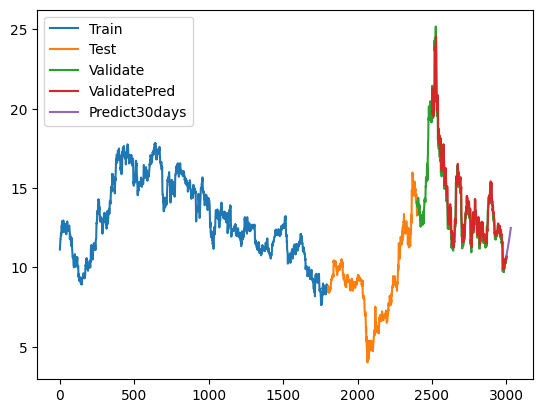

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()